In [39]:
# useful libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# pyspark libs
from pyspark import SparkContext

from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.mllib.feature import StandardScaler, Normalizer, HashingTF, IDF
from pyspark.mllib.linalg import Vectors, SparseVector
from pyspark.mllib.stat import Statistics

from pyspark.ml.feature import StringIndexer, VectorIndexer, Imputer

In [40]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation

In [41]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.sql import SQLContext, SparkSession, Row, Window

In [42]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, Tokenizer, HashingTF, IDF
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import when

#### Load the pre-processed dataframe

In [43]:
ss = SparkSession.builder.appName("ML").getOrCreate()

24/01/08 12:04:04 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [44]:
# Read the CSV file with multiline values (description and facilities)
data = ss.read.options(header = True, inferSchema = True, multiline = True, escape = "\"").csv("dataframe_totalCleaned.csv")
# Show the corrected description and facilities fields
data.count()
len(data.columns)

27

In [45]:
#why geo_plz??????

#from pyspark.sql.functions import col
#data = data.withColumn("geo_plz", col("geo_plz").cast("string"))

In [46]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

24/01/08 12:04:10 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [47]:
df = data
# Define ordinal columns to be indexed
ordinal_columns = ["condition", "interiorQual"]

# Define boolean columns to be combined
boolean_columns = ["balcony", "hasKitchen", "cellar", "lift", "garden"]

# Create indexers for ordinal columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid="keep") for column in ordinal_columns]

# Combine boolean columns into a single column using a custom function
def combine_boolean_columns(*args):
    return [1 if arg else 0 for arg in args]

combine_boolean_udf = spark.udf.register("combine_boolean_udf", combine_boolean_columns)

# Apply the custom function to create a new column "combined_boolean"
df = df.withColumn("combined_boolean", combine_boolean_udf(*boolean_columns))

# Create an indexer for the new "combined_boolean" column
boolean_indexer = StringIndexer(inputCol="combined_boolean", outputCol="combined_boolean_index", handleInvalid="keep")

# Apply one-hot encoding to specific columns
one_hot_columns = ["regio1", "heatingType", "firingTypes", "petsAllowed", "streetPlain", "typeOfFlat", "regio2", "regio3"]
one_hot_encoders = [StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid="keep") for column in one_hot_columns]

# Apply one-hot encoding for indexed columns
one_hot_encoders.append(OneHotEncoder(inputCols=[column + "_index" for column in one_hot_columns], 
                                      outputCols=[column + "_onehot" for column in one_hot_columns]))

# Create a pipeline
pipeline = Pipeline(stages=indexers + [boolean_indexer] + one_hot_encoders)

# Fit and transform the data using the pipeline
model = pipeline.fit(df)
df_transformed = model.transform(df)

24/01/08 12:04:10 WARN SimpleFunctionRegistry: The function combine_boolean_udf replaced a previously registered function.


In [48]:
columns_to_drop = [ 'regio1',
 'heatingType',
 'balcony',
 'firingTypes',
 'hasKitchen',
 'cellar',
 'condition',
 'interiorQual',
 'petsAllowed',
 'streetPlain',
 'lift',
 'typeOfFlat',
 'geo_plz',
 'garden',
 'regio2',
 'regio3',
'condition_index',
 'interiorQual_index',
 'combined_boolean_index',
 'regio1_index',
 'heatingType_index',
 'firingTypes_index',
 'petsAllowed_index',
 'streetPlain_index',
 'typeOfFlat_index',
 'regio2_index',
 'regio3_index'
]

df_cleaned = df_transformed.drop(*columns_to_drop)

In [49]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover


In [50]:
# Convert text to lowercase
df_cleaned = df_cleaned.withColumn("processed_description", lower(col("description")))
#df_cleaned.printSchema()

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re
from pyspark.ml.feature import Tokenizer
def german_tokenize(text):
    if text is None:
        return []
    # Define a regex pattern for tokenization (including German umlauts and sharp s)
    pattern = r'\b\w+\b'
    tokens = re.findall(pattern, text, flags=re.UNICODE)
    return tokens

# Create a user-defined function (UDF)
german_tokenize_udf = udf(german_tokenize, ArrayType(StringType()))

# Apply tokenization to the DataFrame
df_cleaned = df_cleaned.withColumn("processed_description_tokens", german_tokenize_udf("processed_description"))



In [52]:
# Removing German stopwords
german_stopwords = ['der', 'die', 'das', 'und', 'in', 'ein', 'eine']  # Add more stopwords as needed
remover = StopWordsRemover(inputCol="processed_description" + "_tokens", outputCol="processed_description" + "_filtered_tokens", stopWords=german_stopwords)
df_cleaned = remover.transform(df_cleaned)

In [53]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Define the TF-IDF stages
hashingTF = HashingTF(inputCol="processed_description_filtered_tokens", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Create a pipeline
tfidf_pipeline = Pipeline(stages=[hashingTF, idf])

# Fit and transform the data
df_tfidf = tfidf_pipeline.fit(df_cleaned).transform(df_cleaned)

In [54]:
from pyspark.ml.feature import Word2Vec

# Define the Word2Vec model
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="processed_description_filtered_tokens", outputCol="word_embeddings")

# Fit and transform the data
word2vec_model = word2vec.fit(df_cleaned)
df_word2vec = word2vec_model.transform(df_cleaned)


In [55]:
cols_drop =["processed_description" ,"processed_description_tokens" ,"processed_description_filtered_tokens","processed_description_filtered_tokens"]
df_last=df_word2vec.drop(*cols_drop)

In [56]:
col_del=["processed_description","processed_description_filtered_tokens","rawFeatures","features"]
df_idf=df_tfidf.drop(*col_del)

In [57]:
# Convert text to lowercase
df_last = df_last.withColumn("facilities_description", lower(col("facilities")))
#df_cleaned.printSchema()
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

def german_tokenize(text):
    if text is None:
        return []
    # Define a regex pattern for tokenization (including German umlauts and sharp s)
    pattern = r'\b\w+\b'
    tokens = re.findall(pattern, text, flags=re.UNICODE)
    return tokens

# Create a user-defined function (UDF)
german_tokenize_udf = udf(german_tokenize, ArrayType(StringType()))

# Apply tokenization to the DataFrame
df_last = df_last.withColumn("facilities_description_tokens", german_tokenize_udf("facilities_description"))

# Show the result
#df_last.select("facilities_description", "facilities_description_tokens").show(truncate=False)

# Removing German stopwords
german_stopwords = ['der', 'die', 'das', 'und', 'in', 'ein', 'eine']  # Add more stopwords as needed
remover = StopWordsRemover(inputCol="facilities_description" + "_tokens", outputCol="facilities_description" + "_filtered_tokens", stopWords=german_stopwords)
df_last = remover.transform(df_last)


# Define the TF-IDF stages
hashingTF = HashingTF(inputCol="facilities_description_filtered_tokens", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Create a pipeline
tfidf_pipeline = Pipeline(stages=[hashingTF, idf])

# Fit and transform the data
df_tfidf = tfidf_pipeline.fit(df_last).transform(df_last)

# Show the result
#df_tfidf.select("facilities_description_filtered_tokens", "features").limit(10).show(truncate=False)

from pyspark.ml.feature import Word2Vec

# Define the Word2Vec model
word2vec = Word2Vec(vectorSize=100, minCount=5, inputCol="facilities_description_filtered_tokens", outputCol="word_embeddings_fac")

# Fit and transform the data
word2vec_model = word2vec.fit(df_last)
df_word2vec = word2vec_model.transform(df_last)


In [58]:
cols_drop =["description","facilities","facilities_description" ,"facilities_description_tokens" ,"facilities_description_filtered_tokens"]
df_word2vec=df_word2vec.drop(*cols_drop)

In [59]:
df_transformed_selected=df_word2vec

In [60]:
from pyspark.sql.functions import round

# Specify the columns to round
columns_to_round = ["log_pictureCount", "log_yearConstructed", "log_noRooms", 
                     "log_floor", "log_numberOfFloors", "log_serviceCharge", 
                     "log_baseRent", "log_livingSpace", "log_thermalChar"]

# Define the number of decimal places
decimal_places = 2

# Round the specified columns to the specified number of decimal places
for column in columns_to_round:
    df_transformed_selected = df_transformed_selected.withColumn(column, round(col(column), decimal_places))

# Show the DataFrame with rounded columns
#df_transformed_selected.show(truncate=False)

In [61]:
cols_median=df_transformed_selected.columns      

In [62]:
from pyspark.sql.functions import col, split
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when

# Assuming df_transformed_selected is your DataFrame
# Assuming the 'combined_boolean' column is a StringType containing a string representation of a list

# Split the string into an array of integers
split_col = split(df_transformed_selected['combined_boolean'], ',')
df_transformed_selected = df_transformed_selected.withColumn('combined_boolean', split_col)

# Create separate columns for each value and cast them to integers
num_values = len(df_transformed_selected.select('combined_boolean').first()[0])
for i in range(num_values):
    # Create a new column with the boolean representation
    df_transformed_selected = df_transformed_selected.withColumn(
        f'boolean_value_{i}', 
        when(col('combined_boolean')[i] == 1, 1).otherwise(0))

In [63]:
df_transformed_selected.drop("combined_boolean")

DataFrame[log_pictureCount: double, log_yearConstructed: double, log_noRooms: double, log_floor: double, log_numberOfFloors: double, log_serviceCharge: double, log_baseRent: double, log_livingSpace: double, log_thermalChar: double, regio1_onehot: vector, heatingType_onehot: vector, firingTypes_onehot: vector, petsAllowed_onehot: vector, streetPlain_onehot: vector, typeOfFlat_onehot: vector, regio2_onehot: vector, regio3_onehot: vector, word_embeddings: vector, word_embeddings_fac: vector, boolean_value_0: int, boolean_value_1: int, boolean_value_2: int, boolean_value_3: int, boolean_value_4: int]

In [64]:
feature_columns = ["log_pictureCount","log_yearConstructed","log_noRooms","log_floor","log_numberOfFloors","log_serviceCharge",
                   "log_livingSpace","log_thermalChar","regio1_onehot","heatingType_onehot","firingTypes_onehot","petsAllowed_onehot",
                   "streetPlain_onehot","typeOfFlat_onehot","regio2_onehot","regio3_onehot","word_embeddings","word_embeddings_fac", "boolean_value_0", "boolean_value_1", "boolean_value_2", "boolean_value_3", "boolean_value_4"]

target_column = ["log_baseRent"]

In [65]:
# Selecting relevant columns from the DataFrame
selected_columns = feature_columns + target_column
print(selected_columns)
df_selected = df_transformed_selected.select(*selected_columns)

['log_pictureCount', 'log_yearConstructed', 'log_noRooms', 'log_floor', 'log_numberOfFloors', 'log_serviceCharge', 'log_livingSpace', 'log_thermalChar', 'regio1_onehot', 'heatingType_onehot', 'firingTypes_onehot', 'petsAllowed_onehot', 'streetPlain_onehot', 'typeOfFlat_onehot', 'regio2_onehot', 'regio3_onehot', 'word_embeddings', 'word_embeddings_fac', 'boolean_value_0', 'boolean_value_1', 'boolean_value_2', 'boolean_value_3', 'boolean_value_4', 'log_baseRent']


for column in df_selected.columns:
    null_count = df_selected.where(col(column).isNull()).count()
    print(f"Number of null values in column '{column}': {null_count}")



In [66]:
df_selected = df_selected.na.drop(subset=["log_pictureCount","log_yearConstructed","log_noRooms","log_floor","log_numberOfFloors","log_serviceCharge",
                   "log_livingSpace","log_thermalChar","log_baseRent"])

for column in df_selected.columns:
    null_count = df_selected.where(col(column).isNull()).count()
    print(f"Number of null values in column '{column}': {null_count}")


In [67]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
indexed_data=df_selected

cols_dr = ["petsAllowed_onehot","boolean_value_0","boolean_value_4"]
indexed_data.drop(*cols_dr)
indexed_data.drop(*cols_dr)

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(indexed_data)


Create assembled dataset and split train and test

# start

In [68]:
train,test=assembled_data.randomSplit([0.8, 0.2], seed=1234)

for column in ['boolean_value_0',
 'boolean_value_1',
 'boolean_value_2',
 'boolean_value_3',
 'boolean_value_4']:
    distinct_values = train.select(column).distinct()
    print(f"Distinct values in {column}:")
    distinct_values.show()

In [69]:
train.columns

['log_pictureCount',
 'log_yearConstructed',
 'log_noRooms',
 'log_floor',
 'log_numberOfFloors',
 'log_serviceCharge',
 'log_livingSpace',
 'log_thermalChar',
 'regio1_onehot',
 'heatingType_onehot',
 'firingTypes_onehot',
 'petsAllowed_onehot',
 'streetPlain_onehot',
 'typeOfFlat_onehot',
 'regio2_onehot',
 'regio3_onehot',
 'word_embeddings',
 'word_embeddings_fac',
 'boolean_value_0',
 'boolean_value_1',
 'boolean_value_2',
 'boolean_value_3',
 'boolean_value_4',
 'log_baseRent',
 'features']

In [70]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [71]:
target_column = "log_baseRent"

# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol=target_column)

# Train the model
model = lr.fit(train)

# Make predictions on the testing set
predictions = model.transform(test)

# Display predicted results
predictions.select("features", target_column, "prediction").show()

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

24/01/08 12:11:04 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:11:44 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:19 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:20 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:21 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:22 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:23 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:25 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:26 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:28 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:29 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/01/08 12:12:31 WARN DAGScheduler: Broadcasting larg

+--------------------+------------+--------------------+
|            features|log_baseRent|          prediction|
+--------------------+------------+--------------------+
|(41524,[1,2,3,4,5...|        0.12| 0.15452484426989577|
|(41524,[1,3,4,5,6...|        0.08| 0.07766426810814298|
|(41524,[1,3,4,5,6...|        0.04|0.011783789801724662|
|(41524,[1,3,4,5,6...|        0.04|0.017648654802825126|
|(41524,[1,3,4,5,6...|         0.1| 0.08894613755461701|
|(41524,[1,3,4,5,6...|         0.1| 0.13042155360101698|
|(41524,[1,3,4,5,6...|        0.04| 0.00811468749164126|
|(41524,[1,3,4,5,6...|        0.06| 0.10772319853049486|
|(41524,[1,2,3,4,5...|        0.14| 0.12709534009042245|
|(41524,[1,2,3,5,6...|        0.09| 0.08347658792569686|
|(41524,[1,2,3,4,5...|         0.1| 0.10172167218610842|
|(41524,[1,2,3,4,5...|        0.08| 0.05227118148423251|
|(41524,[1,2,3,4,5...|        0.16| 0.15140259882540363|
|(41524,[1,2,3,4,5...|        0.14| 0.13171906489016605|
|(41524,[1,2,3,4,5...|        0

24/01/08 12:17:24 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


Root Mean Squared Error (RMSE) on test data: 0.0197534531391412


24/01/08 12:33:21 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


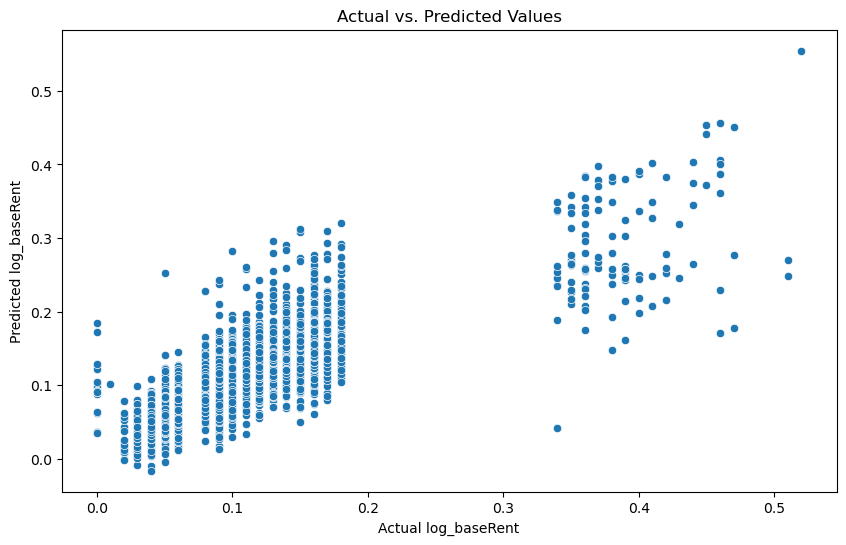

In [74]:
predictions_pd = predictions.select(target_column, "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=target_column, y="prediction", data=predictions_pd)
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual " + target_column)
plt.ylabel("Predicted " + target_column)
plt.show()

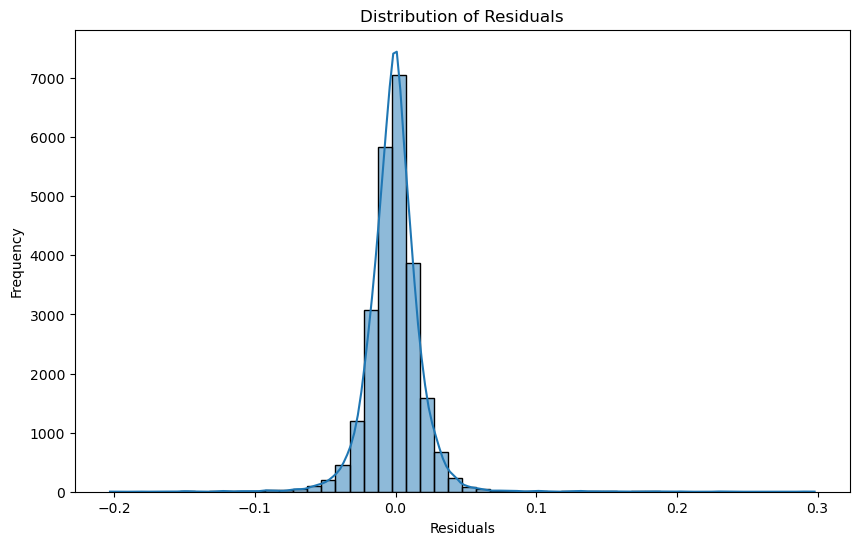

In [75]:
residuals = predictions_pd[target_column] - predictions_pd["prediction"]

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

24/01/08 13:07:18 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


+--------------------+------------+--------------------+
|            features|log_baseRent|          prediction|
+--------------------+------------+--------------------+
|(41524,[1,2,3,4,5...|        0.12| 0.15452484426989577|
|(41524,[1,3,4,5,6...|        0.08| 0.07766426810814298|
|(41524,[1,3,4,5,6...|        0.04|0.011783789801724662|
|(41524,[1,3,4,5,6...|        0.04|0.017648654802825126|
|(41524,[1,3,4,5,6...|         0.1| 0.08894613755461701|
|(41524,[1,3,4,5,6...|         0.1| 0.13042155360101698|
|(41524,[1,3,4,5,6...|        0.04| 0.00811468749164126|
|(41524,[1,3,4,5,6...|        0.06| 0.10772319853049486|
|(41524,[1,2,3,4,5...|        0.14| 0.12709534009042245|
|(41524,[1,2,3,5,6...|        0.09| 0.08347658792569686|
|(41524,[1,2,3,4,5...|         0.1| 0.10172167218610842|
|(41524,[1,2,3,4,5...|        0.08| 0.05227118148423251|
|(41524,[1,2,3,4,5...|        0.16| 0.15140259882540363|
|(41524,[1,2,3,4,5...|        0.14| 0.13171906489016605|
|(41524,[1,2,3,4,5...|        0

24/01/08 13:07:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


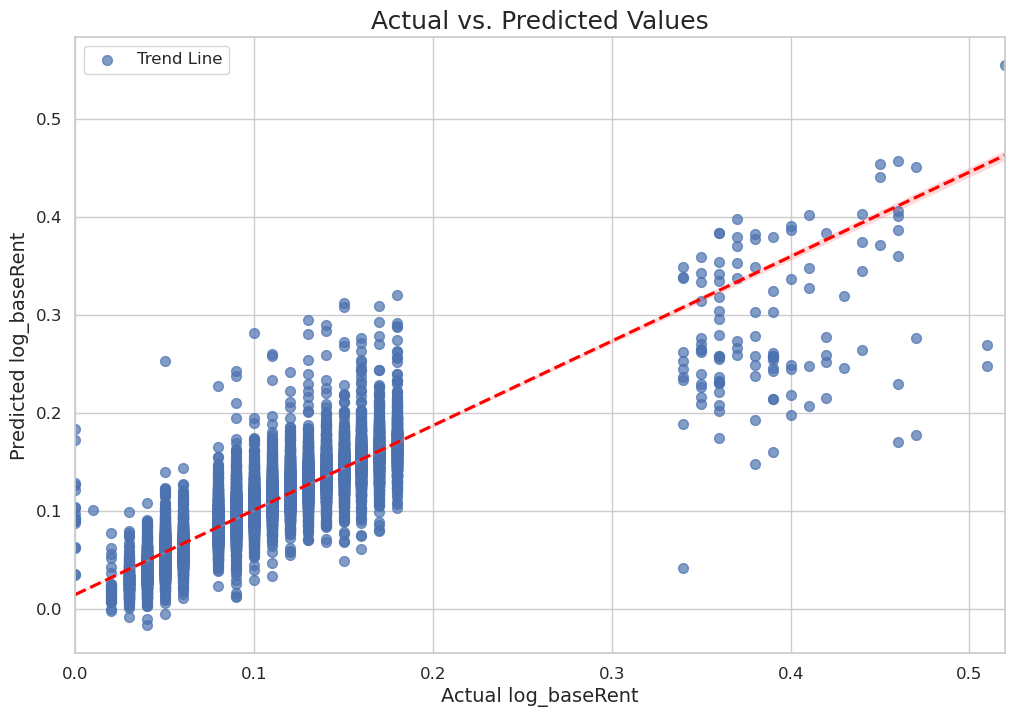

In [78]:
predictions.select("features", target_column, "prediction").show()

# Actual vs. Predicted Plot with Custom Styling
predictions_pd = predictions.select(target_column, "prediction").toPandas()

# Set a custom color palette
custom_palette = sns.color_palette("husl", n_colors=10)

# Use a Seaborn theme for a clean look
sns.set(style="whitegrid")

# Create a scatter plot with a trend line
plt.figure(figsize=(12, 8))
sns.regplot(x=target_column, y="prediction", data=predictions_pd, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red', 'linestyle': '--'})

# Customize plot appearance
plt.title("Actual vs. Predicted Values", fontsize=18)
plt.xlabel("Actual " + target_column, fontsize=14)
plt.ylabel("Predicted " + target_column, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(["Trend Line"], loc="upper left", fontsize=12)

# Show the plot
plt.show()

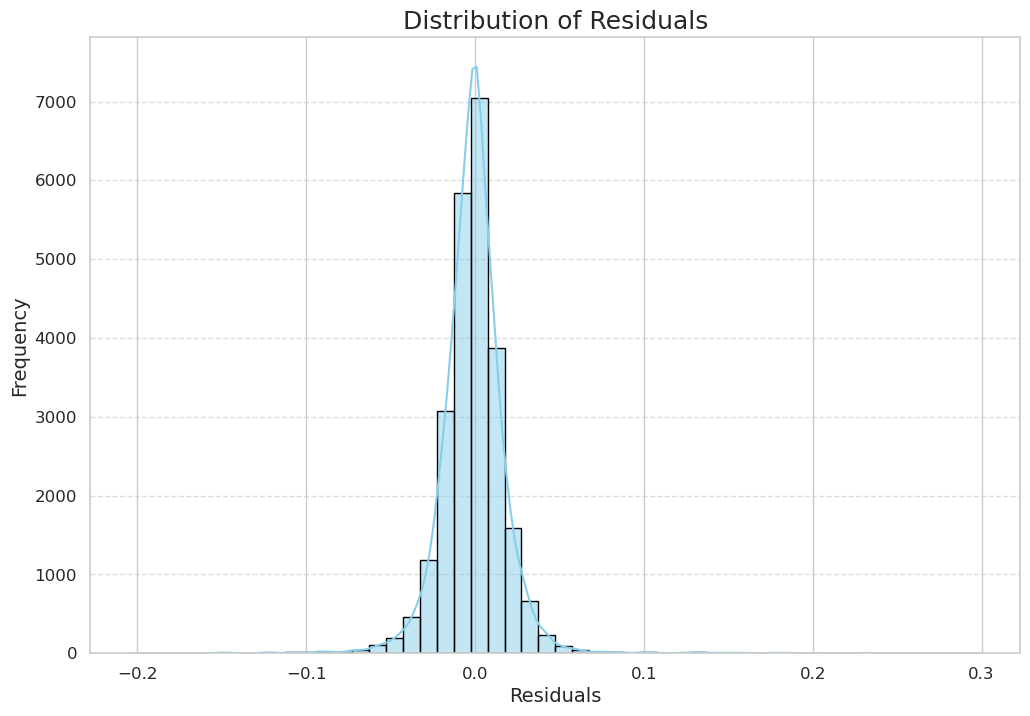

In [79]:
residuals = predictions_pd[target_column] - predictions_pd["prediction"]

# Use a Seaborn theme for a clean look
sns.set(style="whitegrid")

# Create a histogram with KDE plot
plt.figure(figsize=(12, 8))
sns.histplot(residuals, bins=50, kde=True, color='skyblue', edgecolor='black')

# Customize plot appearance
plt.title("Distribution of Residuals", fontsize=18)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

24/01/08 12:38:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
24/01/08 12:39:08 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
24/01/08 12:39:40 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


Root Mean Squared Error (RMSE): 0.0197534531391412
Mean Absolute Error (MAE): 0.013025657590303554
R-squared (R2): 0.8150218115084968


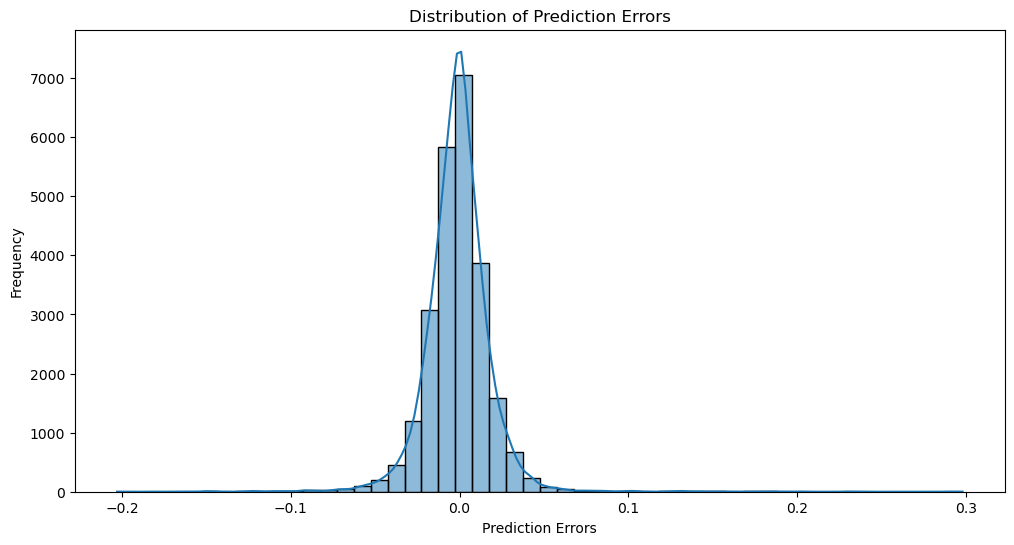

In [77]:
evaluator_rmse = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plotting Prediction Errors
residuals = predictions_pd[target_column] - predictions_pd["prediction"]

plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.show()